In [3]:
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

* [Grayscale](#gray)
* [Gaussian kernel](#gauss)
* [Gradient Calculation](#gradient)
* [Non-Maximum Suppression](#non)
* [Thresholding](#treshold)
* [Hysteresis](#hyst)
* [Canny edge detector with different Gaussian kernels](#canny)

In [4]:
img = Image.open('data/fish.jpg')
data = np.asarray(img)

Image shape : (480, 870, 3)


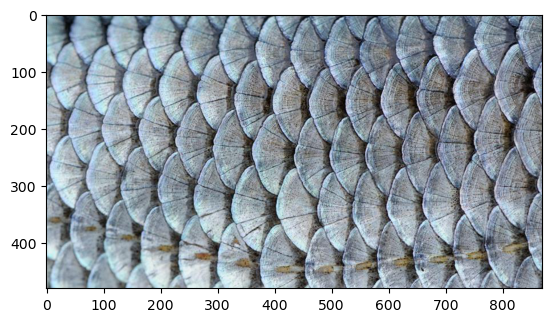

In [5]:
print("Image shape :",data.shape)
imshow(data)

## Grayscale <a id="gray"></a>

In [6]:
def rgb_to_gray_scale(img):
    h = img.shape[0]
    w = img.shape[1]
    transform_img = np.zeros((h, w))
    for h_i in range(h):
        for w_i in range(w):
            transform_img[h_i][w_i] = np.dot(img[h_i][w_i], [0.299 , 0.587, 0.114])
    return transform_img

In [7]:
grey_data = rgb_to_gray_scale(data)

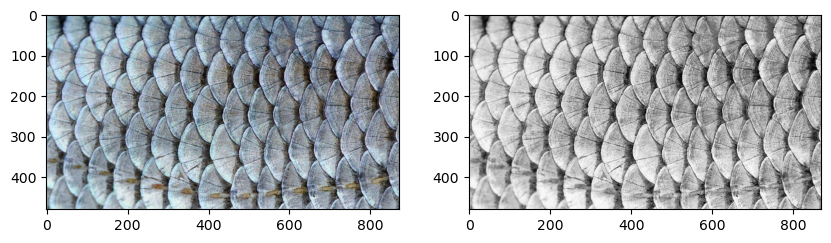

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(data)
axes[1].imshow(grey_data, cmap='Greys_r')

## Gaussian kernel <a class="anchor"  id="gauss"></a>
The equation for a Gaussian filter kernel of size (2k+1)×(2k+1) is given by:
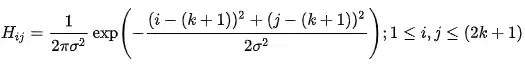

In [9]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g = normal * np.exp(-((x**2 + y**2) / (2.0*sigma**2)))
    return g

In [10]:
gaussian_5 = gaussian_kernel(5)

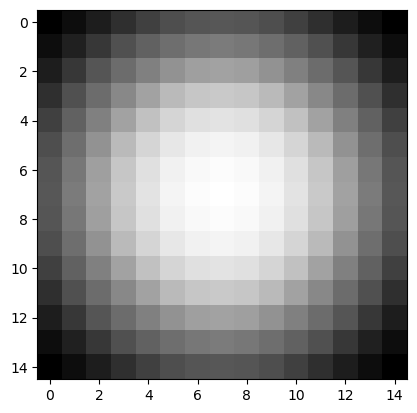

In [12]:
imshow(gaussian_kernel(15, 5), cmap='Greys_r')

In [13]:
def convolution(image, kernel): 
    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape
    output_img = np.zeros(image.shape)
    
    ### add padding
    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)
    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width))) 
    padded_image[pad_height:-pad_height, pad_width:- pad_width] = image
 
    for row in range(image_row):
        for col in range(image_col):
            output_img[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
 
    return output_img

In [16]:
img_gauss = convolution(grey_data, gaussian_kernel(7, 1))

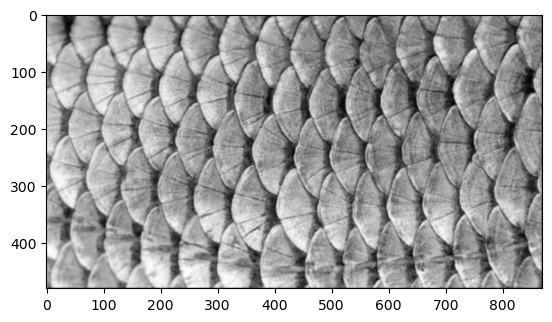

In [17]:
imshow(img_gauss, cmap='gray')

## Gradient Calculation <a class="anchor"  id="gradient"></a>
The Gradient calculation step detects the edge intensity and direction by calculating the gradient of the image using edge detection operators.
When the image is smoothed, the derivatives Ix and Iy w.r.t. x and y are calculated. It can be implemented by convolving I with Sobel kernels Kx and Ky, respectively:

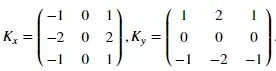

Then, the magnitude G and the slope θ of the gradient are calculated as follow:
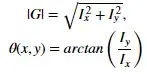

In [18]:
def sobel_filters(img):
    K_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    K_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    img_x = convolution(img, K_x)
    img_y = convolution(img, K_y)
    
    # The same, but with library
    #ndimage.filters.convolve(img, K_x, mode='constant', cval=0.0)
    #ndimage.filters.convolve(img, K_y, mode='constant', cval=0.0)
    
    G = np.hypot(img_x, img_y)
    G *= 255 / G.max()
    
    theta = np.arctan2(img_y, img_x)
    
    return G, theta

In [21]:
img_grad, theta = sobel_filters(img_gauss)

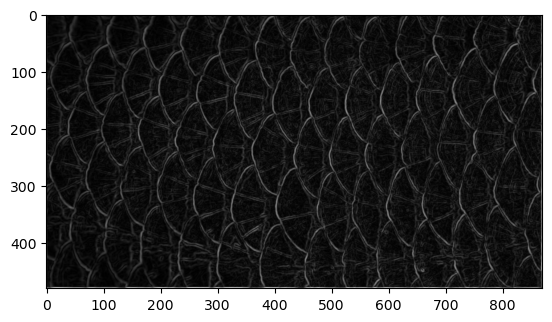

In [22]:
imshow(img_grad, cmap='gray')

## Non-Maximum Suppression <a class="anchor"  id="non"></a>
Our objective is to remove redundant/duplicate edges identified by Sobel Edge Detection ( Refer the image above ). We want just one line to show the edge rather than having multiple lines for the same edge. This can be done by the Non-Max Suppression Algorithm.
A pixel can have total 4 directions for the gradient (shown below) since there are total 8 neighboring pixels.
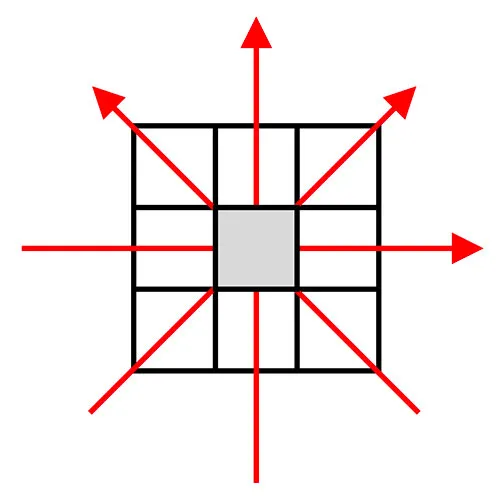

In order to solve this problem, we will consider a range of degrees to select a neighbor. If the direction of the middle pixel is between (-157, 157) and also between (-22.5, 22.5), then we shall compare the middle pixel with the left one right neighbor pixels

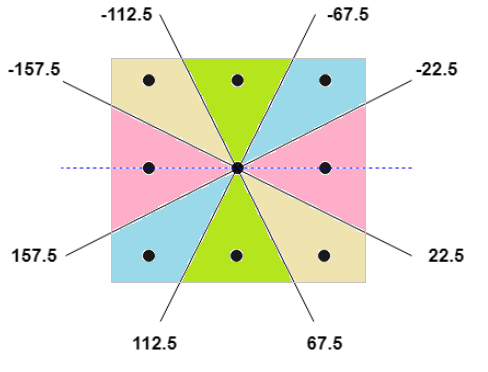

In [24]:
def non_max_suppression(gradient_magnitude, gradient_direction):
    image_row, image_col = gradient_magnitude.shape
    output_img = np.zeros(gradient_magnitude.shape)

    for row in range(1, image_row - 1):
        for col in range(1, image_col - 1):
            direction = gradient_direction[row, col]

            if (0 <= direction < 22.5) or (157.5 <= direction <= 180) \
            or (-22.5 <= direction < 0) or (-180 <= direction < -157.5):
                before_pixel = gradient_magnitude[row, col - 1]
                after_pixel = gradient_magnitude[row, col + 1]

            elif (22.5 <= direction < 67.5) or (-157.5 <= direction < -112.5):
                before_pixel = gradient_magnitude[row + 1, col + 1]
                after_pixel = gradient_magnitude[row - 1, col - 1]

            elif (67.5 <= direction < 112.5) or (-112.5 <= angle[i,j] < -67.5):
                before_pixel = gradient_magnitude[row + 1, col]
                after_pixel = gradient_magnitude[row - 1, col]

            elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
                before_pixel = gradient_magnitude[row + 1, col - 1]
                after_pixel = gradient_magnitude[row - 1, col + 1]

            if gradient_magnitude[row, col] >= before_pixel and gradient_magnitude[row, col] >= after_pixel:
                output_img[row, col] = gradient_magnitude[row, col]

    return output_img

In [25]:
img_non_max_supp = non_max_suppression(img_grad, theta)

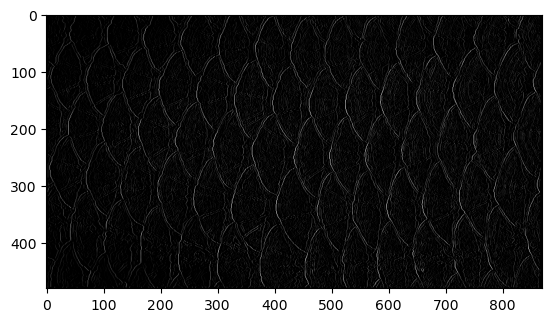

In [26]:
imshow(img_non_max_supp, cmap='gray')

## Thresholding  <a class="anchor"  id="threshold"></a>

The main idea of thresholding, as the name suggest is to take all the edges and define them either week (some low number say 50) or strong ( white – 255 ).

In [27]:
def threshold(image, low, high, weak, verbose=False):
    strong = 255
    output_img = np.zeros(image.shape)
    
    strong_row, strong_col = np.where(image >= high)
    weak_row, weak_col = np.where((image <= high) & (image >= low))
 
    output_img[strong_row, strong_col] = strong
    output_img[weak_row, weak_col] = weak
 
    return output_img

In [31]:
weak = 50
img_treshold = threshold(img_non_max_supp, 15, 60, weak=weak)

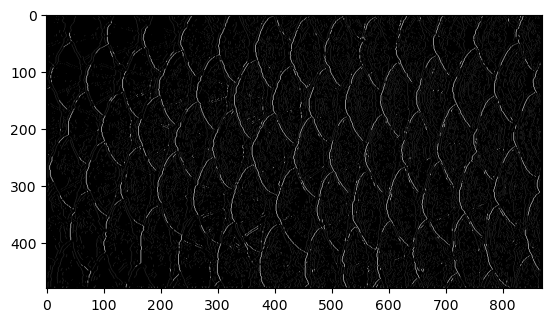

In [32]:
imshow(img_treshold, cmap='gray')

## Hysteresis <a class="anchor"  id="hyst"></a>
So we already have the confirmed edges in white pixel ( 255 ) and other pixels in some weak value ( say 50 ). The objective of the hysteresis function is to identify the weak pixels which can be edges and discard the remaining.

Obvious question is how to determine which pixels are part of real edges? We want to find out whether a selected pixel is connected to the already defined edge pixels, if so we can consider this pixel also to be part of an edge.The simple solution is to find out whether any given pixels neighbors ( as we have seen earlier, there will be total 8 ) has value equal to 255, if yes then change the value of the pixel to 255, otherwise discard the pixel by setting the value to 0.

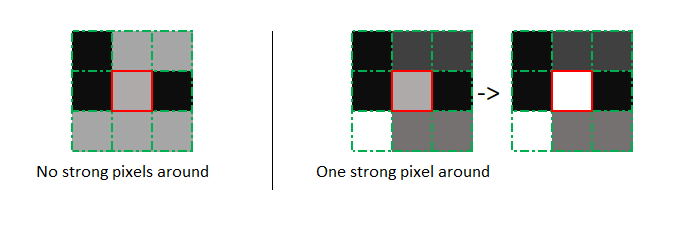

In [30]:
def hysteresis(img, weak, strong=255):
    row, col = img.shape  
    for i in range(1, row-1):
        for j in range(1, col-1):
            if (img[i,j] == weak):
                try:
                    if (
                        (img[i+1, j-1] == strong) or 
                        (img[i+1, j] == strong) or 
                        (img[i+1, j+1] == strong) or 
                        (img[i, j-1] == strong) or 
                        (img[i, j+1] == strong) or 
                        (img[i-1, j-1] == strong) or 
                        (img[i-1, j] == strong) or 
                        (img[i-1, j+1] == strong)
                        ):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [33]:
img_hysteresis = hysteresis(img_treshold, 50, strong=255)

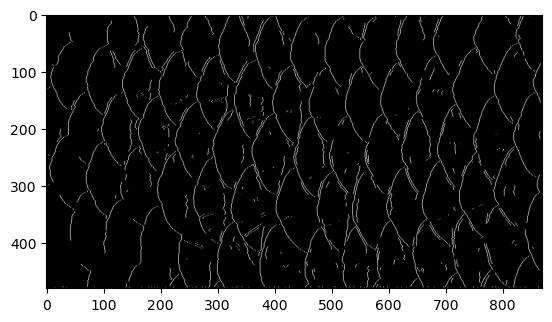

In [34]:
imshow(img_hysteresis, cmap='gray')

## Canny edge detector with different Gaussian kernels <a class="anchor"  id="canny"></a>

In [55]:
img = Image.open('data/flower.jpg')
img = np.asarray(img)

In [56]:
def canny_edge(img, kernel_gauss, treshold_low, treshold_high, weak):
    img_gray = rgb_to_gray_scale(img)
    img_conv = convolution(img_gray, kernel_gauss)    
    img_grad, theta = sobel_filters(img_conv)    
    img_supp = non_max_suppression(img_grad, theta)    
    img_tres = threshold(img_supp, treshold_low, treshold_high, weak)    
    img_hyst = hysteresis(img_tres, weak, strong=255)    
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[1].imshow(kernel_gauss, cmap='Greys_r')  
    axes[2].imshow(img_hyst, cmap='Greys_r')   
    
    axes[0].set_title('Image')
    axes[1].set_title('Kernel')    
    axes[2].set_title('Edges')    

In [59]:
gauss_3_1 = gaussian_kernel(3, 1)
gauss_5_1 = gaussian_kernel(5, 1)
gauss_9_3 = gaussian_kernel(9, 3)
gauss_11_3 = gaussian_kernel(11, 3)
gauss_list = [gauss_3_1, gauss_5_1, gauss_9_3, gauss_11_3]

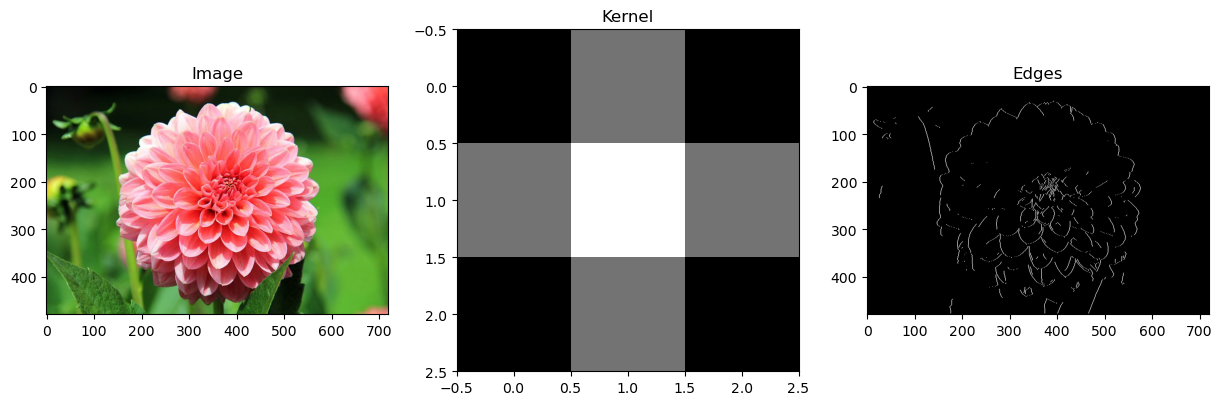

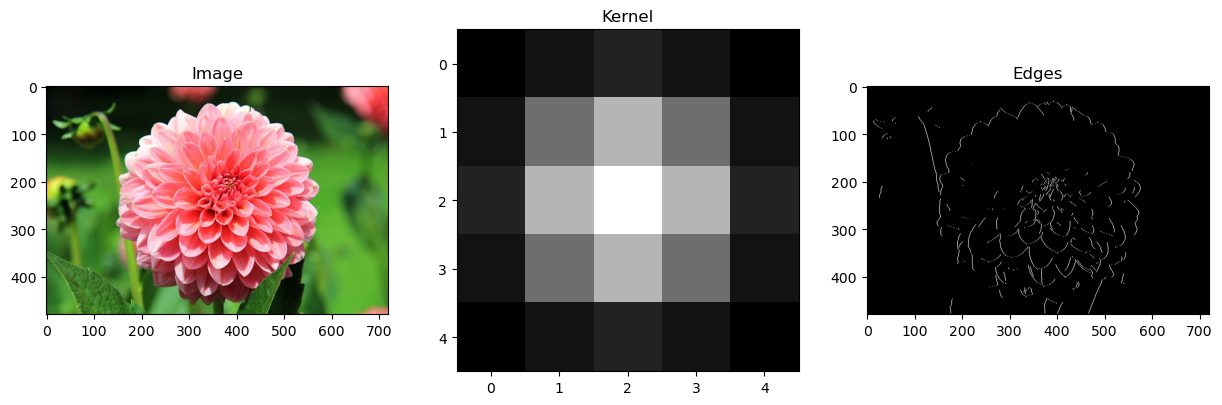

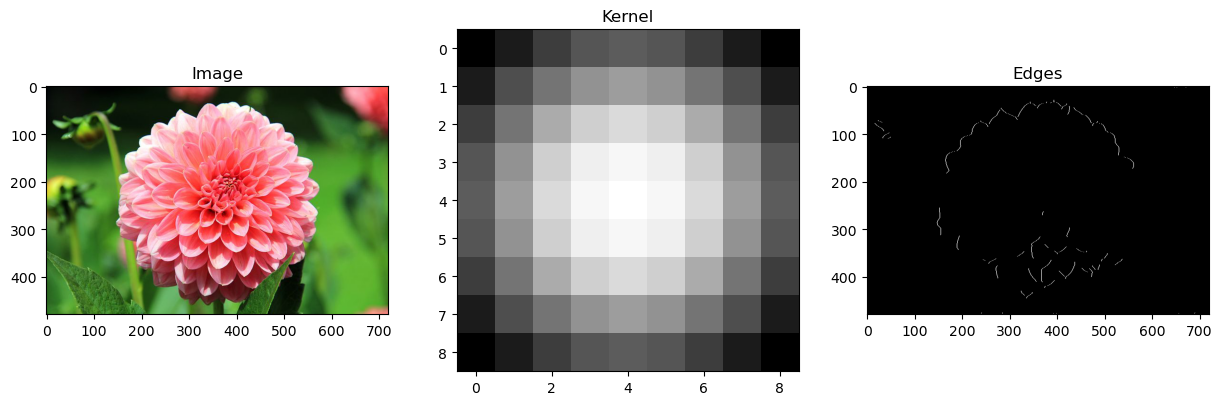

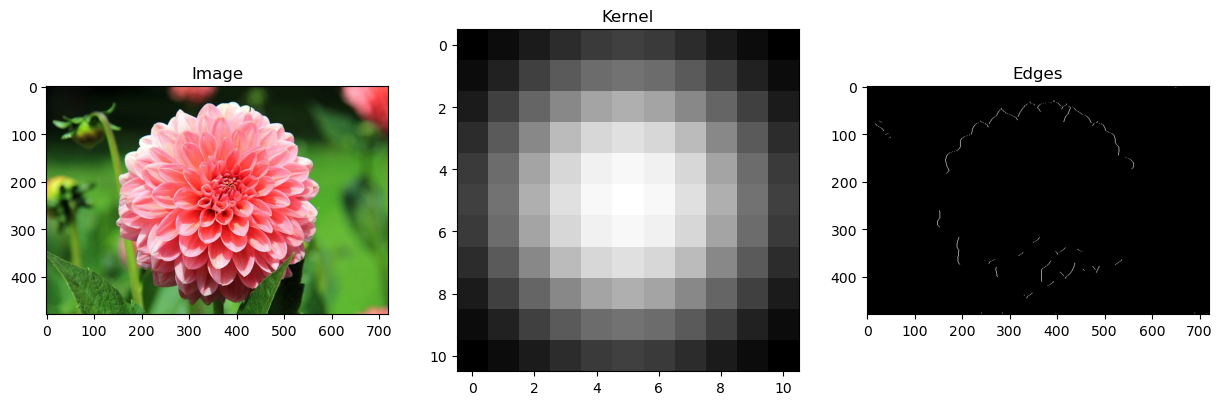

In [61]:
for kernel in gauss_list:
    canny_edge(img, kernel, 10, 70, 70)